# Lab12-6 RNN with time series data(stock)
RNN으로 주식시장을 예측하여 보자.
<br><br>
주식시장은 대표적인 time series data
<br>
Many to one -> 만약 7일간의 time series data를 가지고 내일의 stock 을 예측<br>

기본적인 Idea -> 다음날의 결정은 그 전날의 데이터만 가지고 판단하는 것이 아니라, 그 전 여러날의 data를 살펴봐야 한다.
![lec12_17](../../img/lec12_17.png)

<br>
이제 우리가 고민해야 하는 것은, 입력의 dimension는 얼마인가, sequence의 길이는 얼마인가? 출력의  hidden size는 얼마인가.
![lec12_18](../../img/lec12_18.png)

<br>
1. Input dimension : Open, High, Low, Volume, Close 로 총 5 <br>
2. Sequence Length : 7일간의  data를 보는 것이므로 7<br>
3. Output dimension : 우리는 다음날 하루를 예측하는 것이므로 1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

In [8]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

### Reading data

In [11]:
timesteps = seq_length = 7
data_dim = 5
output_dim = 1

# Open, High, Low, Volume, Close
xy = np.loadtxt('../../data/data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:,[-1]] # Close as label

dataX = []
dataY = []
# 일단 데이터를 한번 찍어보기
for i in range(0, len(y) - seq_length):
    # 5개 씩 (window scan) -> for loop로 구현
    _x = x[i: i + seq_length]
    _y = y[i + seq_length] # Next close price
    print(_x, "->", _y) # _y는 우리가 예측하려는 값 (일단 데이터를 출력)
    dataX.append(_x)
    dataY.append(_y)

[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] -> [0.13289962]
[[1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.3641

### Training and test datasets

In [15]:
# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]

trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataX)])

# input placeholders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])
# None은 Batch size 로 들어감

### LSTM and Loss

In [17]:
hidden_dim = 10

In [18]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# FC를 진행하는 것에 주의 이에 대한 결과로 Y를 예측 -> 그러나, 그 사이의 값은 우리가 정해주면 된다.
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  
    # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

### Training and Results

0 81.533676
1 32.50355
2 7.8573914
3 7.9416046
4 18.992771
5 21.960426
6 17.129978
7 10.283829
8 5.1603556
9 2.886794
10 2.95132
11 4.2463894
12 5.739442
13 6.7506733
14 6.982257
15 6.4394226
16 5.326516
17 3.9511428
18 2.6415653
19 1.6739835
20 1.2103114
21 1.2574286
22 1.6670622
23 2.189999
24 2.5732358
25 2.6578436
26 2.4284635
27 1.9944308
28 1.5227754
29 1.1630485
30 0.9967329
31 1.0239015
32 1.1815565
33 1.378433
34 1.5303264
35 1.5848997
36 1.5314711
37 1.3966212
38 1.2296896
39 1.0836489
40 0.9971809
41 0.9831927
42 1.0272229
43 1.0959806
44 1.1523418
45 1.1703067
46 1.1435977
47 1.0849352
48 1.0176511
49 0.964521
50 0.9389828
51 0.94179404
52 0.9632471
53 0.98884726
54 1.0055885
55 1.0064379
56 0.9918126
57 0.96810627
58 0.9442791
59 0.9280177
60 0.92291903
61 0.92764866
62 0.9371754
63 0.94536614
64 0.94769406
65 0.9428901
66 0.9329535
67 0.921757
68 0.913071
69 0.90896976
70 0.9092465
71 0.91190386
72 0.91432464
73 0.91449857
74 0.9117824
75 0.9069487
76 0.9016142
77 0.89738

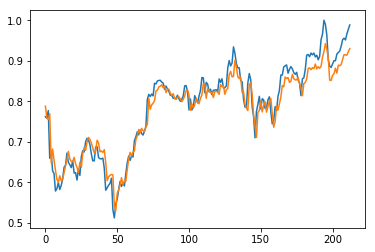

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(1000):
    _, l = sess.run([train, loss], feed_dict = {X:trainX, Y:trainY})
    print(i, l)
    
testPredict = sess.run(Y_pred, feed_dict= {X:testX})

import matplotlib.pyplot as plt
plt.plot(testY)
plt.plot(testPredict)
plt.show()

## Exercise
- Implement stock prediction using linear regression only
- Improve results using more features such as keywords and/or sentiments in top news